In [1]:
import skfda.datasets
from skfda.representation.basis import BSpline,FDataBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch,LinearSmootherGeneralizedCVScorer
from matplotlib import pyplot as plt
import numpy as np

# Load weather dataset

This dataset correspond to daily temperature and precipitation at 35 different locations in Canada averaged over 1960 to 1994.

In [2]:
weather_dataset=skfda.datasets.fetch_weather()['data']

Using TensorFlow backend.
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
weather_dataset.data_matrix.shape # (35,365,2) 35-->nb time series 365-->nb observation 2-->temperature et precipitation 

(35, 365, 2)

### Original dataset

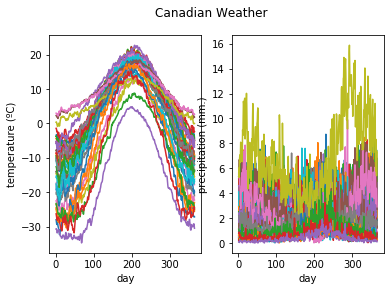

In [4]:
weather_dataset.plot()
print()

How to access to data :

In [5]:
time_step=weather_dataset.sample_points[0]

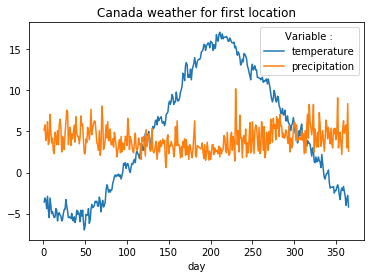

In [6]:
first_timeserie_temperature=weather_dataset.data_matrix[0,:,0]
first_timeserie_precipitation=weather_dataset.data_matrix[0,:,1]
plt.plot(time_step,first_timeserie_temperature,label="temperature")
plt.plot(time_step,first_timeserie_precipitation,label="precipitation")
plt.xlabel("day")
plt.title("Canada weather for first location")
plt.legend(title="Variable :")
plt.show()

# Smooth Curves and analyze shape with CurveAnalysis

In [7]:
from CurveAnalysis import fda_feature

In [8]:
curve_analysis=fda_feature.CurveAnalysis(weather_dataset)

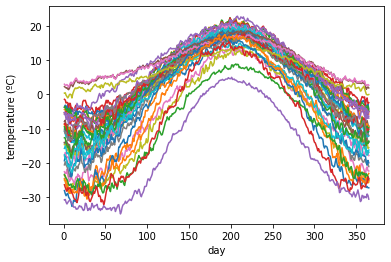

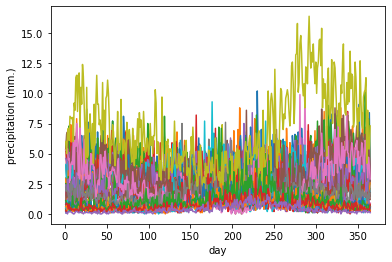

In [9]:
#plot the dataset
curve_analysis.plot_grids()

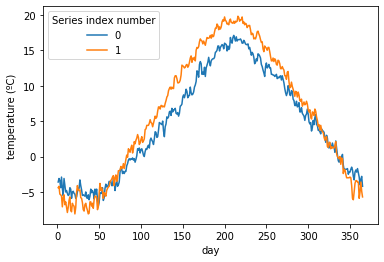

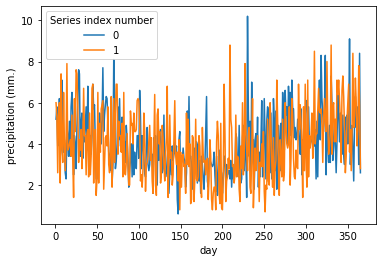

In [10]:
#only plot the first and second time series :
curve_analysis.plot_grids(series_idx=[0,1])

## Smooth data with a basis of function

first step is to choose which basis of function you will use to smooth

In [11]:
#the type of basis function the number of basis and the order are hyperparameter 
basis=BSpline(domain_range=(weather_dataset.domain_range),n_basis=15, order=6)
smoother=BasisSmoother(basis)

As we want a generalized approximation, we dont wan't to overfit the smoothing. To do this we will use a penalized regression and try several **smoothing parameter**

In [12]:
param_values=np.logspace(-8,8,num=25) #for the exemple we will try 25 values between 10^-8 et 10^8

To search the best smoothing parameter we use the method smooth_grids which will basically do a gridsearch crossvalidation for each variable then save the smoothed_data with the best smoothing in **curve_analysis.coordinates_grids**

In [13]:
history=curve_analysis.smooth_grids(smoother=smoother,param_values=param_values,return_history=True)

Smoothing data...



Smoothing Done


if **return_history=true** it will return a numpy array which contains the score of the smoothing for each variable for each smoothing parameter tested, if parameter set to false, it will do the smoothing but return nothing

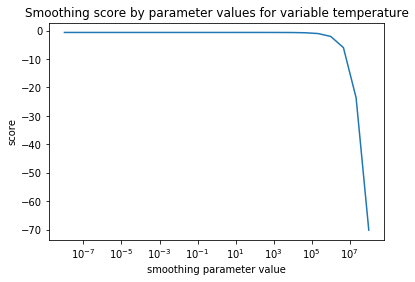

In [14]:
plt.plot(param_values,history[0])
plt.title("Smoothing score by parameter values for variable temperature")
plt.xscale("log")
plt.ylabel("score")
plt.xlabel("smoothing parameter value")
plt.show()

higher the score is, better is the smoothing

In [15]:
print("Best smoothing parameter for temperature smoothing : ", param_values[np.argmax(history[0])])

Best smoothing parameter for temperature smoothing :  100.0


Now let's see for precipitation

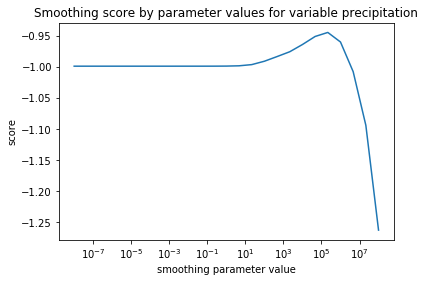

In [16]:
plt.plot(param_values,history[1])
plt.title("Smoothing score by parameter values for variable precipitation")
plt.xscale("log")
plt.ylabel("score")
plt.xlabel("smoothing parameter value")
plt.show()

In [17]:
print("Best smoothing parameter for precipitation smoothing : ", param_values[np.argmax(history[1])])

Best smoothing parameter for precipitation smoothing :  215443.46900318778


To get better result you can try more smoothing parameter or changing basis function type, number of basis functions

## Visualize the smoothed time series

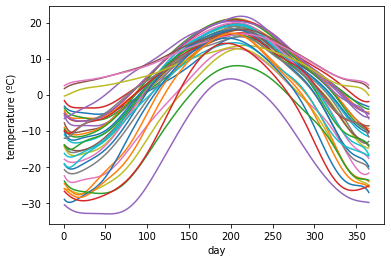

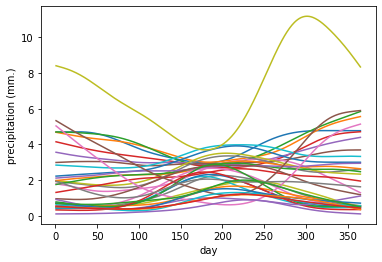

In [18]:
curve_analysis.plot_grids()

compare before and after smoothing for the 4 first time series

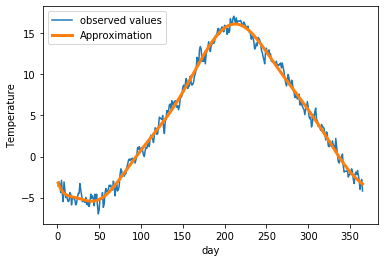

In [19]:
plt.plot(curve_analysis.sample_points,curve_analysis.init_grid.data_matrix[0,:,0],
         label="observed values")
plt.plot(curve_analysis.sample_points,curve_analysis.coordinates_grids[0].data_matrix[0,:,0],
         label="Approximation",linewidth=3)
plt.legend()
plt.ylabel("Temperature")
plt.xlabel("day")
plt.show()

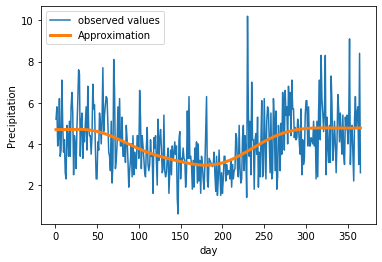

In [20]:
plt.plot(curve_analysis.sample_points,curve_analysis.init_grid.data_matrix[0,:,1],
         label="observed values")
plt.plot(curve_analysis.sample_points,curve_analysis.coordinates_grids[1].data_matrix[0,:,0],
         label="Approximation",linewidth=3)
plt.legend()
plt.ylabel("Precipitation")
plt.xlabel("day")
plt.show()

As we can see our approximation fit well the data and isn't sensible to little variation

We can also see interaction between the two variables, if there is more than 2 variable then the method **plot_interaction** will plot interaction between all variable 2 by 2

like the method **plot_grids**  we can chose which time series to plot with the parameter series_idx, if default value then all the time series are ploted

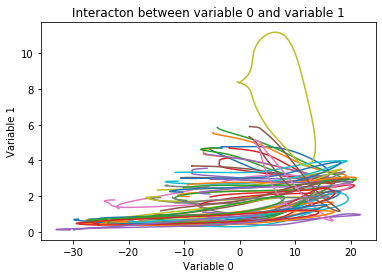

In [21]:
curve_analysis.plot_interaction()

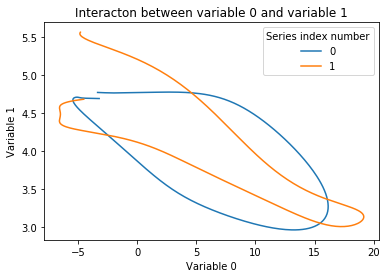

In [22]:
curve_analysis.plot_interaction(series_idx=[0,1])

We can also scale the data before doing analysis

In [23]:
curve_analysis.scale_grids(axis=0,with_std=False)

## Compute based-shape features

Now that our time series are smoothed we want to compute shape feature like the arc length or the series, the veloctiy or the curvature. they are defined as

 $$ arc\_length(t) = \int_0^t \lVert D^1 X(u) \rVert du $$

$$ velocity(t) = \lVert D^1 X(t) \rVert $$

$$  curvature(t)= \frac{\sqrt{\lVert D^1 X(t) \rVert ^2 \lVert D^2 X(t) \rVert ^2 -
<D^1 X(t),D^2 X(t)> ^2}}{\lVert D^1 X(t) \rVert ^3}du $$

To calculate them with the class there are 3 methods : **compute_arc_length**,**compute_velocity** and **compute_curvature**

Those 3 method return data as data grid which is how FDA is represented in skfda package

In [24]:
arc_length=curve_analysis.compute_arc_length()
velocity=curve_analysis.compute_velocity()
curvature=curve_analysis.compute_curvature()

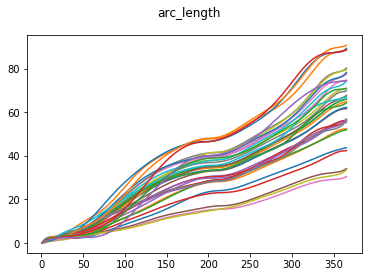

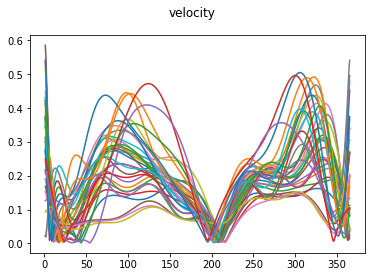

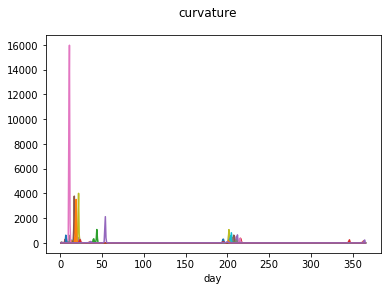

In [25]:
arc_length.plot()
velocity.plot()
curvature.plot()
plt.xlabel("day")
plt.show()

As they are in FDataGrid format you can transform each feature in a 2 dimensionnal matrix :

In [26]:
velocity_array=velocity.data_matrix[:,:,0]
velocity_array.shape

(35, 365)